In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression 
#ensemble technique
from sklearn.ensemble import VotingClassifier, StackingClassifier
# Evaluation Metrics
from sklearn.metrics import accuracy_score, classification_report

# Set a random state for reproducibility
RANDOM_STATE = 42

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
"""********************* load the data **************************"""
print(__doc__)
try:
    df = pd.read_csv('../data/raw/creditcard.csv')
    print("Dataset loaded successfully.")
    print("Dataset shape:", df.shape)
except FileNotFoundError:
    print("\ncreditcard.csv not found.")
    print("Please make sure you have downloaded the dataset and placed it in the 'data/raw/' directory.")
    exit()

# Check for class imbalance

print("\nClass Distribution:")
print(df['Class'].value_counts())

********************* load the data **************************
Dataset loaded successfully.
Dataset shape: (284807, 31)

Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64


In [3]:
"""********************Data processing************************* """
print(__doc__)

# Define features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Scale the 'Time' and 'Amount' columns
scaler = StandardScaler()
X['scaled_amount'] = scaler.fit_transform(X['Amount'].values.reshape(-1, 1))
X['scaled_time'] = scaler.fit_transform(X['Time'].values.reshape(-1, 1))

# Drop the original 'Time' and 'Amount' columns
X = X.drop(['Time', 'Amount'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print(f"\nData split into training and testing sets.")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")



********************Data processing************************* 

Data split into training and testing sets.
Training set shape: (227845, 30)
Test set shape: (56962, 30)


In [4]:
"""******************** Balancing the Data using SMOTE ***********************"""
print(__doc__)
print("\nOriginal Training Set Class Distribution:", Counter(y_train))

smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Training Set Class Distribution After SMOTE:", Counter(y_train_smote))

******************** Balancing the Data using SMOTE ***********************

Original Training Set Class Distribution: Counter({0: 227451, 1: 394})
Training Set Class Distribution After SMOTE: Counter({0: 227451, 1: 227451})


In [6]:
"""********************Apply and Evaluate Base ML Algorithms ***********************"""
print(__doc__)
from sklearn.utils import resample

# --- Create a subsample for the slow SVM model ---
print("Preparing a subsample of the balanced data for faster SVM training...")
X_train_smote_sample, y_train_smote_sample = resample(X_train_smote,
                                                      y_train_smote,
                                                      n_samples=50000, # Using 50k samples is a good balance
                                                      random_state=RANDOM_STATE,
                                                      stratify=y_train_smote)

print(f"Subsample created with {len(y_train_smote_sample)} data points.")


# --- Initialize the models ---
models = {
    "Support Vector Machine": SVC(probability=True, random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# --- Dictionary to store the results ---
results = {}

# --- Loop to train and evaluate each model ---
for name, model in models.items():
    print(f"\n--- Training {name} ---")
    
    # Use the smaller sample for SVM and the full data for others
    if name == "Support Vector Machine":
        model.fit(X_train_smote_sample, y_train_smote_sample)
    else:
        model.fit(X_train_smote, y_train_smote)
    
    # Make predictions on the original, unseen test data
    y_pred = model.predict(X_test)
    
    # Calculate accuracy and store it
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    
    # Print the performance metrics
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    # This report is crucial as it shows performance on the minority class (Class 1)
    print(classification_report(y_test, y_pred, target_names=['Not Fraud (Class 0)', 'Fraud (Class 1)']))

print("\n--- Base model training and evaluation complete. ---")

********************Apply and Evaluate Base ML Algorithms ***********************
Preparing a subsample of the balanced data for faster SVM training...
Subsample created with 50000 data points.

--- Training Support Vector Machine ---
Accuracy: 0.9802
Classification Report:
                     precision    recall  f1-score   support

Not Fraud (Class 0)       1.00      0.98      0.99     56864
    Fraud (Class 1)       0.07      0.91      0.14        98

           accuracy                           0.98     56962
          macro avg       0.54      0.94      0.56     56962
       weighted avg       1.00      0.98      0.99     56962


--- Training Random Forest ---
Accuracy: 0.9994
Classification Report:
                     precision    recall  f1-score   support

Not Fraud (Class 0)       1.00      1.00      1.00     56864
    Fraud (Class 1)       0.81      0.81      0.81        98

           accuracy                           1.00     56962
          macro avg       0.91      0.


--- Preparing ensembles using faster models (RF and KNN) ---

--- Training Voting Classifier (Hard) ---
Accuracy: 0.9994

--- Training Voting Classifier (Soft/Average) ---
Accuracy: 0.9991

--- Training Weighted Average Classifier ---
Accuracy: 0.9994

--- Training Stacking Classifier ---
Accuracy: 0.9995


C:\Users\HP\AppData\Local\Temp\ipykernel_19348\1247673731.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')



Comparison chart saved to 'reports/figures/model_comparison_chart.png'


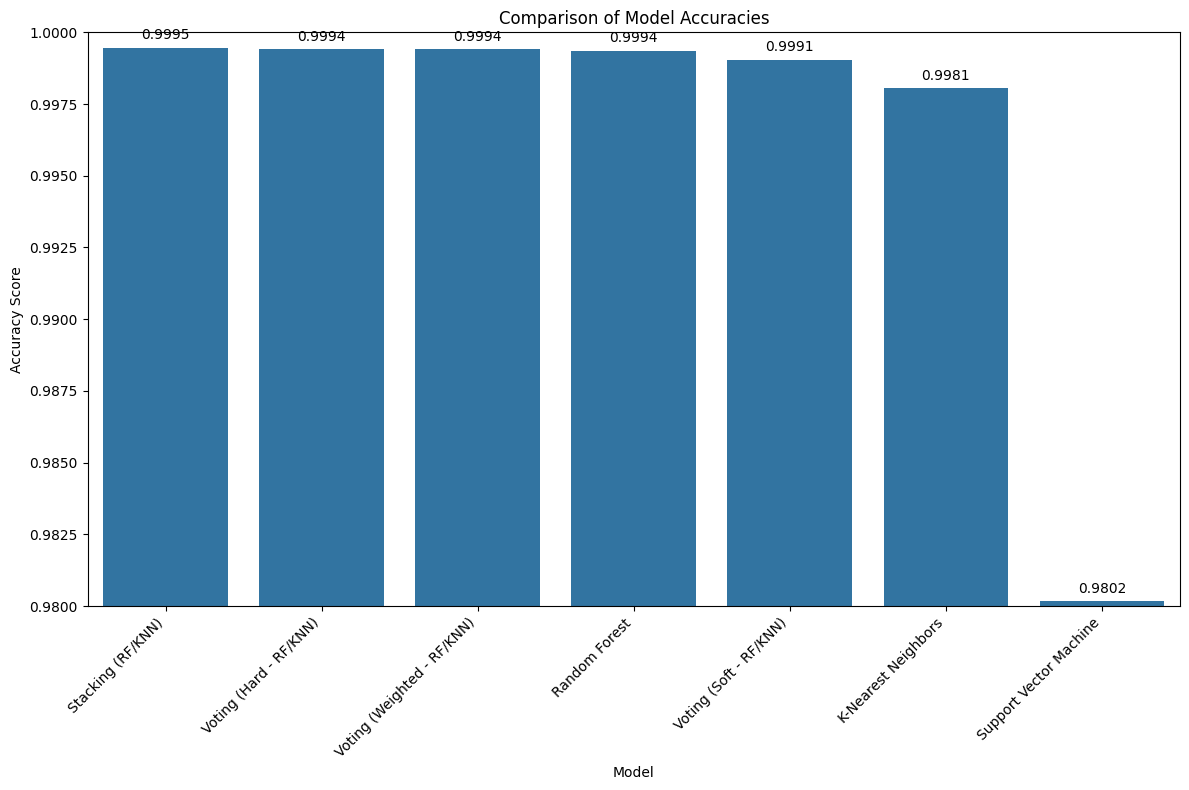


--- Final Model Comparison ---
                        Model  Accuracy
6           Stacking (RF/KNN)  0.999456
3      Voting (Hard - RF/KNN)  0.999403
5  Voting (Weighted - RF/KNN)  0.999403
1               Random Forest  0.999350
4      Voting (Soft - RF/KNN)  0.999052
2         K-Nearest Neighbors  0.998051
0      Support Vector Machine  0.980162


In [7]:
"""
******************* Apply Ensemble Techniques******************
"""
# Because the SVM is too slow to train on the full dataset, we will build
# our ensembles using only the two faster models: Random Forest and KNN.
# This is a common practical decision in machine learning.

print("\n--- Preparing ensembles using faster models (RF and KNN) ---")

# Define the estimators list WITHOUT the slow SVM
estimators_fast = [
    ('rf', models['Random Forest']),
    ('knn', models['K-Nearest Neighbors'])
]

# --- 1. Voting Classifier (Hard) ---
print("\n--- Training Voting Classifier (Hard) ---")
voting_clf_hard = VotingClassifier(estimators=estimators_fast, voting='hard')
# We fit on the full SMOTE data, which is fine for these fast models
voting_clf_hard.fit(X_train_smote, y_train_smote)
y_pred_voting_hard = voting_clf_hard.predict(X_test)
accuracy_voting_hard = accuracy_score(y_test, y_pred_voting_hard)
results['Voting (Hard - RF/KNN)'] = accuracy_voting_hard
print(f"Accuracy: {accuracy_voting_hard:.4f}")

# --- 2. Averaging (Soft Voting) ---
print("\n--- Training Voting Classifier (Soft/Average) ---")
voting_clf_soft = VotingClassifier(estimators=estimators_fast, voting='soft')
voting_clf_soft.fit(X_train_smote, y_train_smote)
y_pred_voting_soft = voting_clf_soft.predict(X_test)
accuracy_voting_soft = accuracy_score(y_test, y_pred_voting_soft)
results['Voting (Soft - RF/KNN)'] = accuracy_voting_soft
print(f"Accuracy: {accuracy_voting_soft:.4f}")

# --- 3. Weighted Averaging ---
# We can adjust weights based on the base models' performance.
# Let's assume RF is slightly better than KNN from Step 4.
print("\n--- Training Weighted Average Classifier ---")
weights = [0.6, 0.4] # 60% weight to RF, 40% to KNN
weighted_avg_clf = VotingClassifier(estimators=estimators_fast, voting='soft', weights=weights)
weighted_avg_clf.fit(X_train_smote, y_train_smote)
y_pred_weighted = weighted_avg_clf.predict(X_test)
accuracy_weighted = accuracy_score(y_test, y_pred_weighted)
results['Voting (Weighted - RF/KNN)'] = accuracy_weighted
print(f"Accuracy: {accuracy_weighted:.4f}")

# --- 4. Stacking ---
print("\n--- Training Stacking Classifier ---")
stacking_clf = StackingClassifier(estimators=estimators_fast, final_estimator=LogisticRegression())
stacking_clf.fit(X_train_smote, y_train_smote)
y_pred_stacking = stacking_clf.predict(X_test)
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
results['Stacking (RF/KNN)'] = accuracy_stacking
print(f"Accuracy: {accuracy_stacking:.4f}")


"""# Step 6: Final Comparison Chart"""



results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy']).sort_values(by='Accuracy', ascending=False)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Model', y='Accuracy', data=results_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Comparison of Model Accuracies')
plt.ylabel('Accuracy Score')
plt.xlabel('Model')
plt.ylim(0.98, 1.0) 

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.tight_layout()

# Save the figure to the 'reports/figures' directory
plt.savefig('../reports/figures/model_comparison_chart.png')
print("\nComparison chart saved to 'reports/figures/model_comparison_chart.png'")

plt.show()

print("\n--- Final Model Comparison ---")
print(results_df)